# Apartat B

In [1]:
# Càrrega de llibreries

import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from prettytable import PrettyTable
import time
warnings.filterwarnings('ignore')

In [2]:
# Càrrega de les dades d'iris
iris = datasets.load_iris()

# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

n_classes = 3

[00:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+-----------------------+------+---------------------+-------------

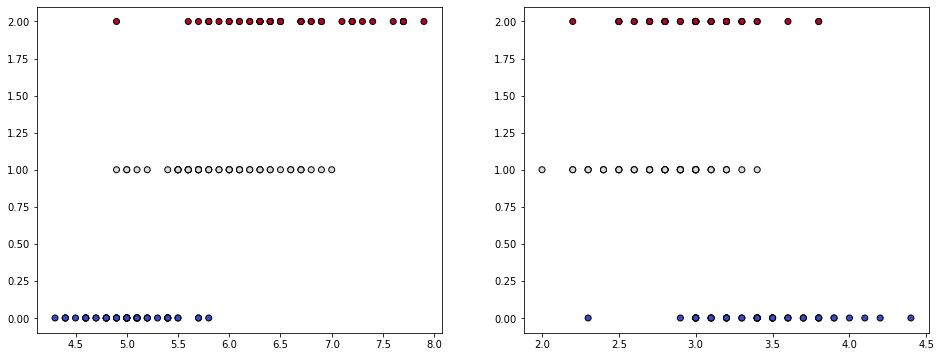

In [3]:
# Prova de diversos models per classificar les dades del dataset iris
    
fig, sub = plt.subplots(1, 2, figsize=(16,6))
sub[0].scatter(X[:,0], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
sub[1].scatter(X[:,1], y, c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Prova de cada model fent servir diverses proporcions train/test
particions = [0.5, 0.7, 0.8]

ptbl = PrettyTable()
ptbl.field_names=['Model', 'Part', 'Accuracy', 'Time']

probs = []
model_names = ['Logistic', 'SVM', 'Decision Tree Gini', 'Decision Tree Entropy',
              'Random Forest', 'Ada Boost Classifier', 'XGBoost']

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    start = time.time()
    # REGRESSIÓ LOGÍSTICA
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)
    # l'entrenem
    logireg.fit(x_t, y_t)
    #time.sleep(1)
    end = time.time()
    if part == 0.8:
        probs.append(logireg.predict_proba(x_v))
    ptbl.add_row(['Logistic', part, logireg.score(x_v,y_v),end-start])

    # MÀQUINA DE VECTORS DE SUPORT
    start = time.time()
    svc = svm.SVC(C=10.0, kernel='rbf', gamma=0.9, probability=True)
    svc.fit(x_t, y_t)
    #time.sleep(1)
    end = time.time()
    if part == 0.8:
        probs.append(svc.predict_proba(x_v))
    ptbl.add_row(['SVM', part, svc.score(x_v,y_v),end-start])
    
    # IMPLEMENTACIÓ PRÒPIA:

    # DESICION TREE (amb criterion gini i entropy)
    start = time.time()
    decision_tree_gini = DecisionTreeClassifier(criterion = 'gini')
    decision_tree_entropy =  DecisionTreeClassifier(criterion = 'entropy')
    decision_tree_gini.fit(x_t,y_t)
    decision_tree_entropy.fit(x_t,y_t)
    end = time.time()
    if part == 0.8:
        probs.append(decision_tree_gini.predict_proba(x_v))
    if part == 0.8:
        probs.append(decision_tree_entropy.predict_proba(x_v))
    ptbl.add_row(['Decision Tree Gini', part, decision_tree_gini.score(x_v,y_v),end-start])
    ptbl.add_row(['Decision Tree Entropy', part, decision_tree_entropy.score(x_v,y_v),end-start])

    # RANDOM FOREST
    start = time.time()
    rf = RandomForestClassifier(n_estimators = 100)
    rf.fit(x_t,y_t)
    end = time.time()
    if part == 0.8:
        probs.append(rf.predict_proba(x_v))
    ptbl.add_row(['Random Forest', part, rf.score(x_v,y_v),end-start])
    
    # ADA BOOST
    start = time.time()
    abc = AdaBoostClassifier()
    abc.fit(x_t,y_t)
    end = time.time()
    if part == 0.8:
        probs.append(abc.predict_proba(x_v))
    ptbl.add_row(['Ada Boost Classifier', part, abc.score(x_v,y_v),end-start])

    # XG BOOST
    start = time.time()
    xboost = xgb.XGBClassifier()
    xboost.fit(x_t,y_t)
    end = time.time()
    if part == 0.8:
        probs.append(xboost.predict_proba(x_v))
    ptbl.add_row(['XGBoost', part, xboost.score(x_v,y_v),end-start])

# Mostra de la taula d'accuracies i de temps per cada model i cada proporció
print(ptbl)

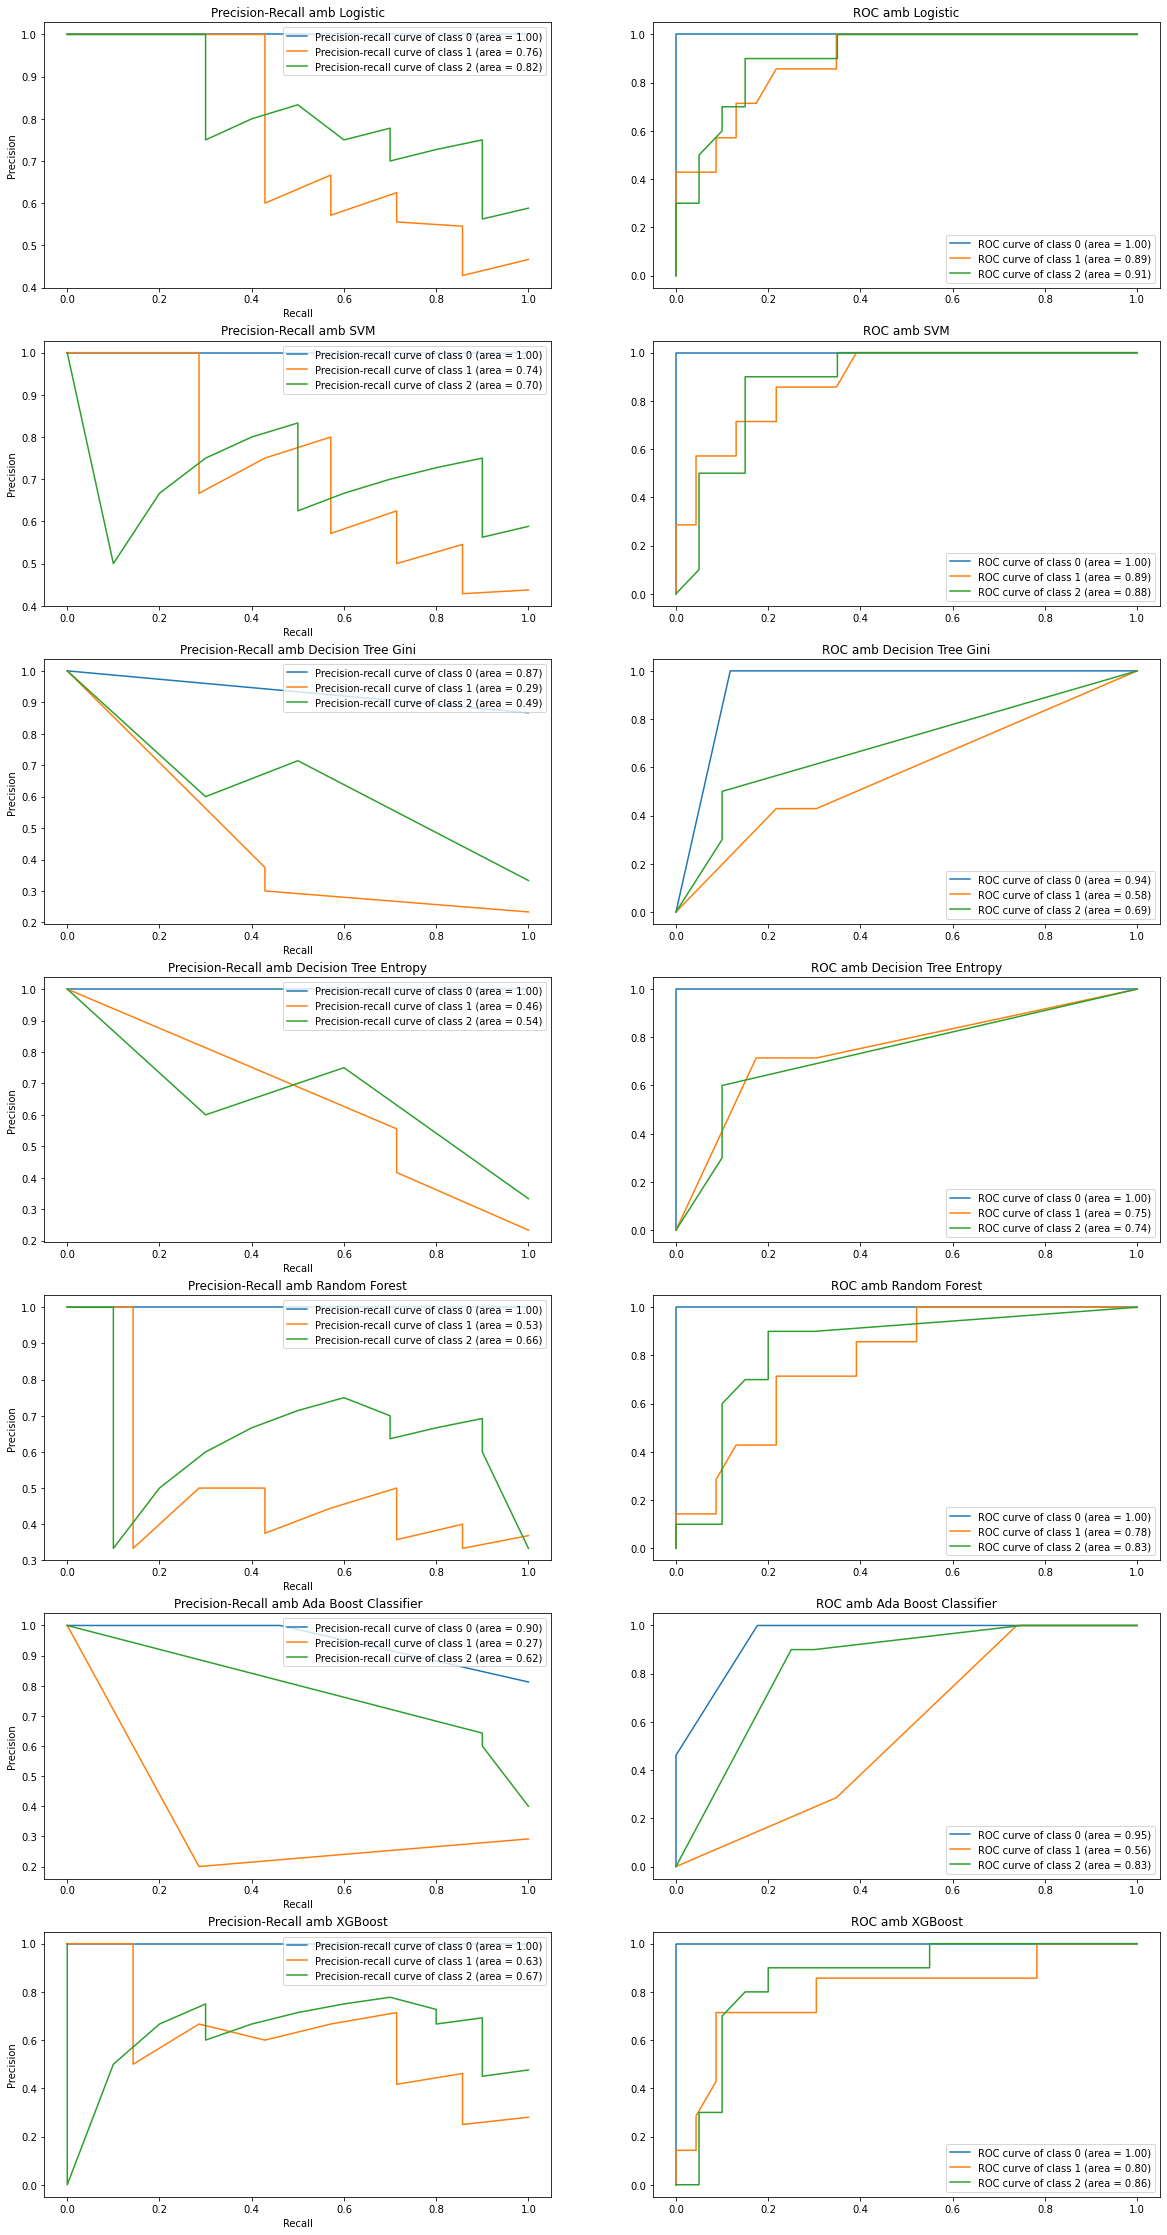

In [4]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

n_classes = 3

# Càlcul i dibuix de les corbes de precision-recall
def plot_precision_recall(probs, ax, title, y_v=y_v):
    precision = {}
    recall = {}
    average_precision = {}
    #ax.figure()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
        average_precision[i] = average_precision_score(y_v == i, probs[:, i])

        ax.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc="upper right")
    ax.set_title(title)
    return

    
# Càlcul i dibuix de les corbes de ROC
def ROC(probs, ax, title, y_v=y_v):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #plt.figure()
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    ax.legend()
    ax.set_title(title)
    return

fig, axes = plt.subplots(7,2,figsize=(20,40))
ax = axes.ravel()

i = 0
j = 0
for p in probs:
    plot_precision_recall(p, ax[i], 'Precision-Recall amb ' + model_names[j])
    ROC(p, ax[i+1], 'ROC amb ' + model_names[j])
    j += 1
    i += 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Funcions per visualitzar els resultats de les classificacions amb diversos
# valors de coeficients de regularització.

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def show_C_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    iris = datasets.load_iris()
    # Take the first two features. We could avoid this by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    titles = ['SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel',
             'Logistic']
    for i in range(len(titles)):
        titles[i] = titles[i] + ' with C = ' + str(C)

    #C = 1.0  # SVM regularization parameter
    models = (svm.SVC(kernel='linear', C=C),
              svm.LinearSVC(C=C, max_iter=1000000),
              svm.SVC(kernel='rbf', gamma=gamma, C=C),
              svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C),
              LogisticRegression(C=C, fit_intercept=True, penalty='l2', tol=0.001)
)
    models = (clf.fit(X, y) for clf in models)

    plt.close('all')
    fig, sub = plt.subplots(3, 2, figsize=(14,12))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()
    
def show_gamma_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    iris = datasets.load_iris()
    # Take the first two features. We could avoid this by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    titles = ['SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel']
    for i in range(len(titles)):
        titles[i] = titles[i] + ' with gamma = ' + str(gamma)

    #C = 1.0  # SVM regularization parameter
    models = (svm.SVC(kernel='rbf', gamma=gamma, C=C),
              svm.SVC(kernel='poly', degree=degree, gamma=gamma, C=C))
    models = (clf.fit(X, y) for clf in models)

    plt.close('all')
    fig, sub = plt.subplots(1, 2, figsize=(14,5))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Sepal length')
        ax.set_ylabel('Sepal width')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

def show_degree_effect(C=1.0, gamma=0.7, degree=3):

    # import some data to play with
    iris = datasets.load_iris()
    # Take the first two features. We could avoid this by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    # we create an instance of SVM and fit out data. We do not scale our
    # data since we want to plot the support vectors
    # title for the plots
    title = 'SVC with polynomial (degree ' + str(degree) + ') kernel'

    #C = 1.0  # SVM regularization parameter
    model = svm.SVC(kernel='poly', degree=degree, gamma='auto', C=C)
    model = model.fit(X, y)

    plt.close('all')
    fig, sub = plt.subplots(1, 1, figsize=(14,12))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(sub, model, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    sub.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    sub.set_xlim(xx.min(), xx.max())
    sub.set_ylim(yy.min(), yy.max())
    sub.set_xlabel('Sepal length')
    sub.set_ylabel('Sepal width')
    sub.set_xticks(())
    sub.set_yticks(())
    sub.set_title(title)

    plt.show()

C = 0.0001


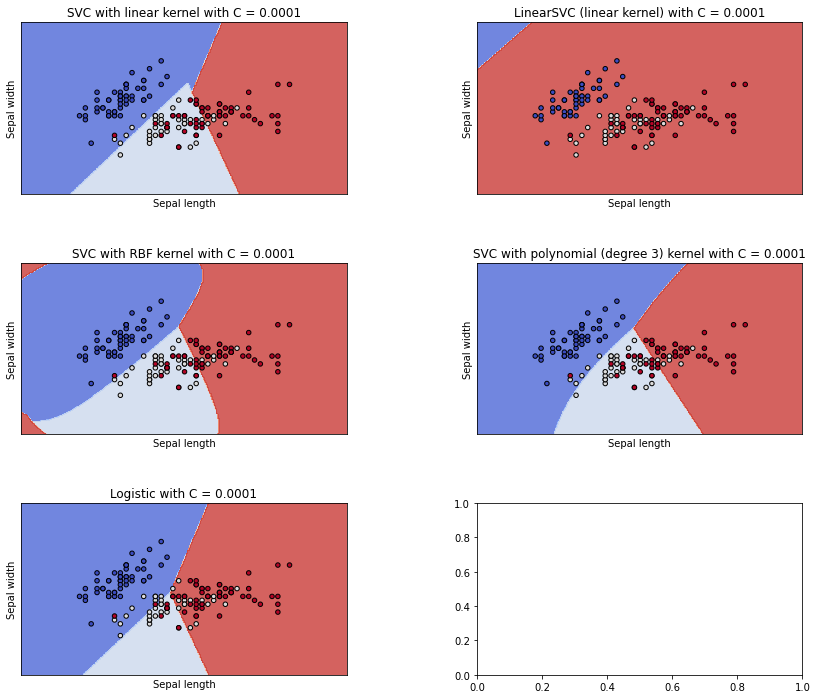

C = 0.001


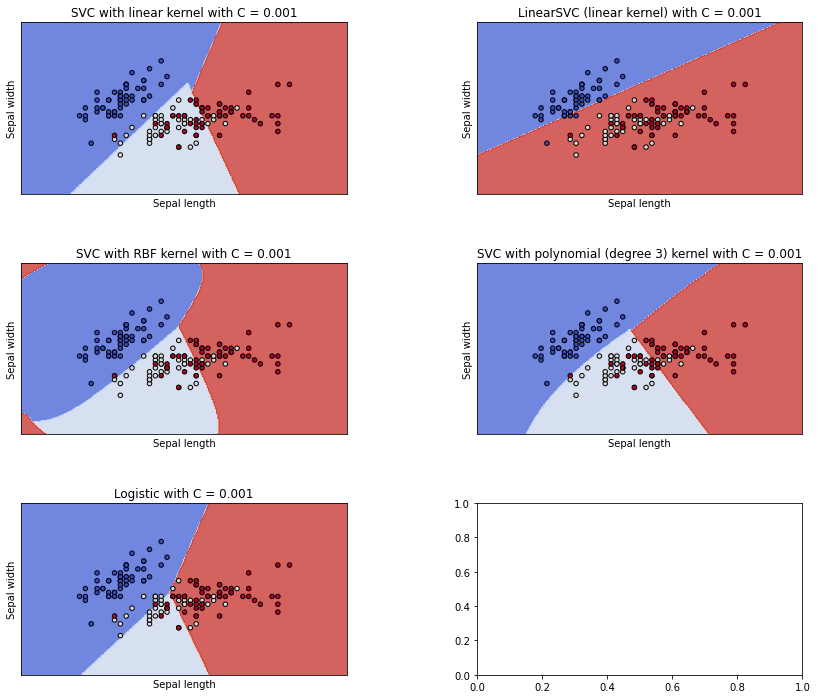

C = 0.01


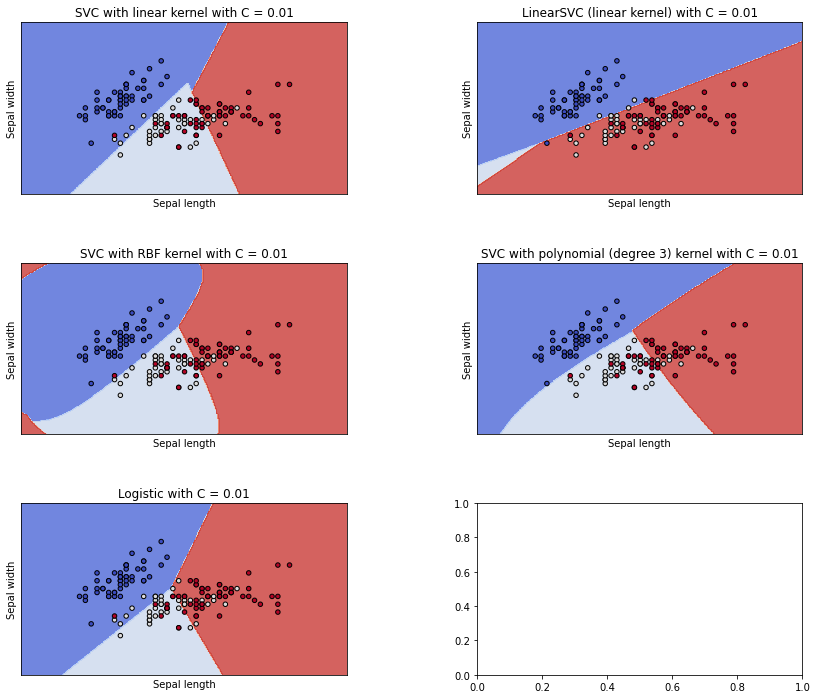

C = 0.1


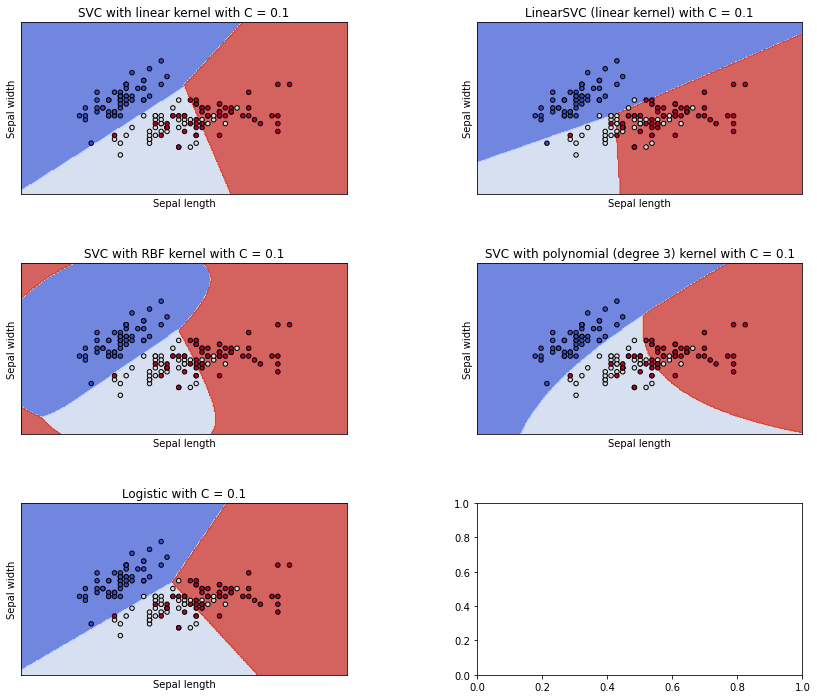

C = 1


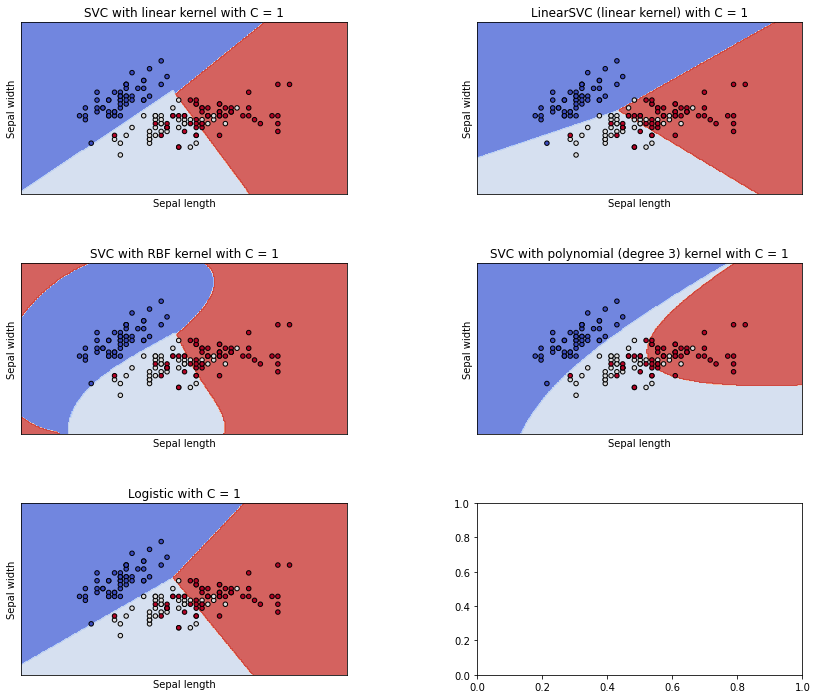

C = 10


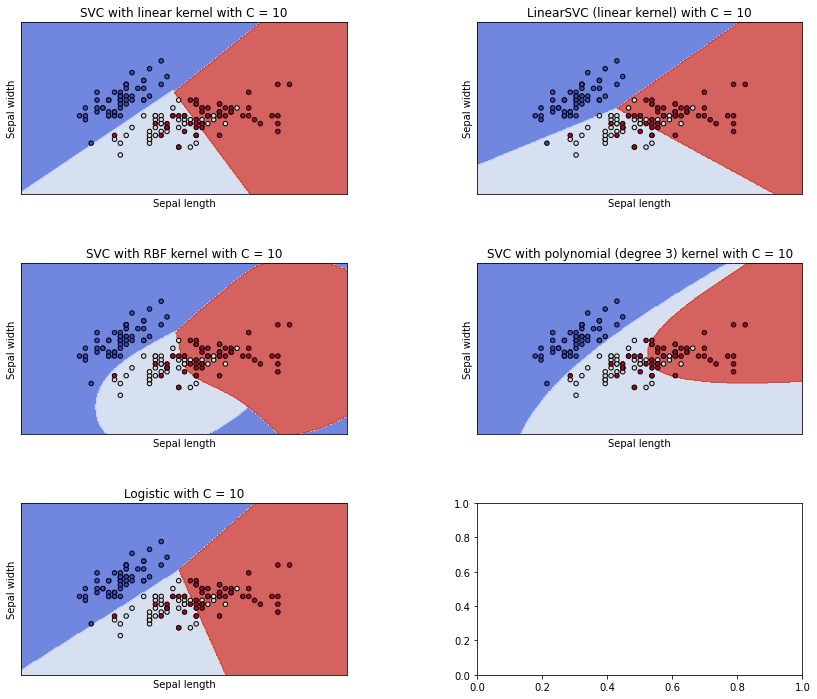

C = 100


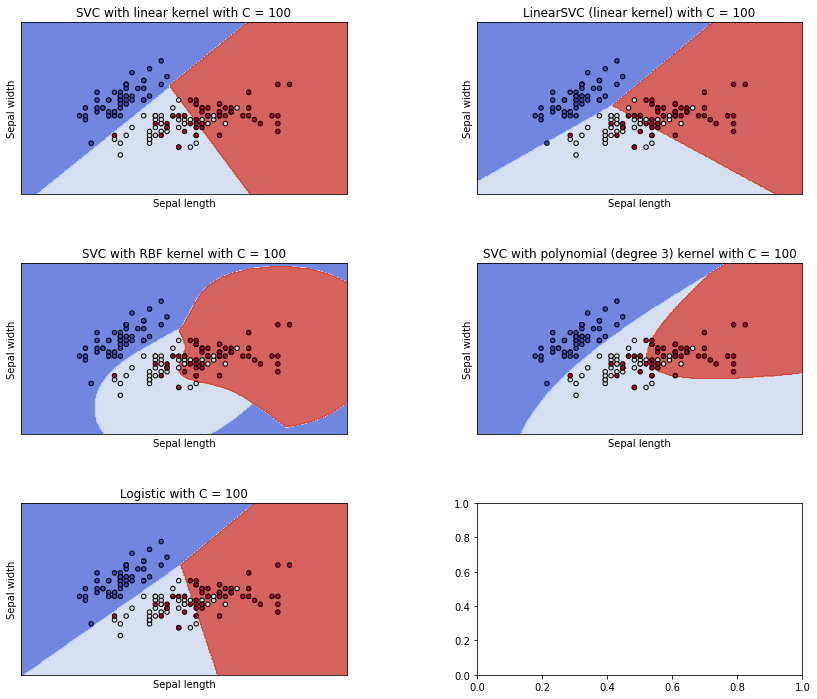

C = 1000


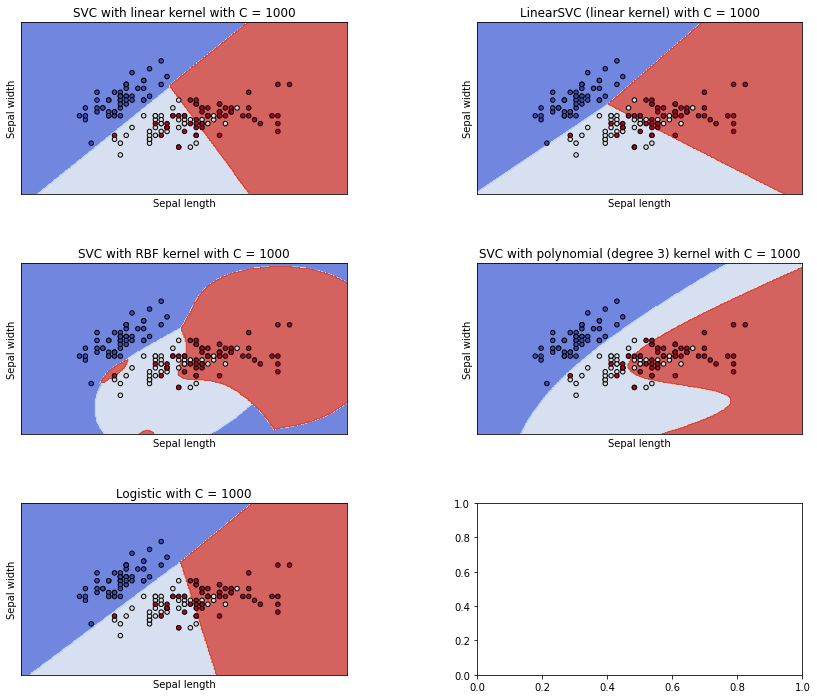

In [6]:
# Visualització de la classificació duta a terme per diversos valors de C.

C_values = [10**x for x in range(-4,4)]
fig, axes = plt.subplots(10,2,figsize=(10,20))
ax = axes.ravel()
idx=0
for C in C_values:
    print('C = ' + str(C))
    ax[idx] = show_C_effect(C=C)
    idx+=1
fig.tight_layout()

gamma = 0.0001


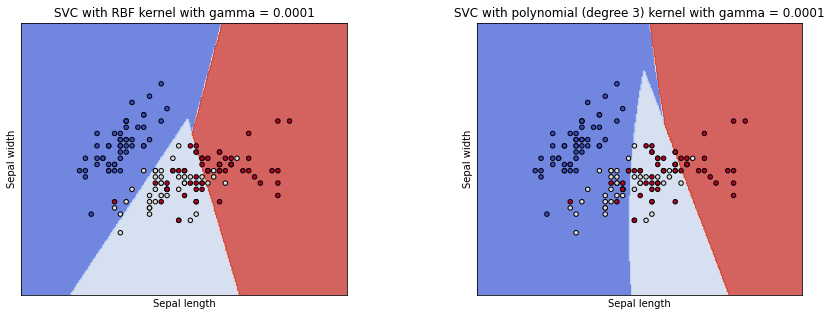

gamma = 0.001


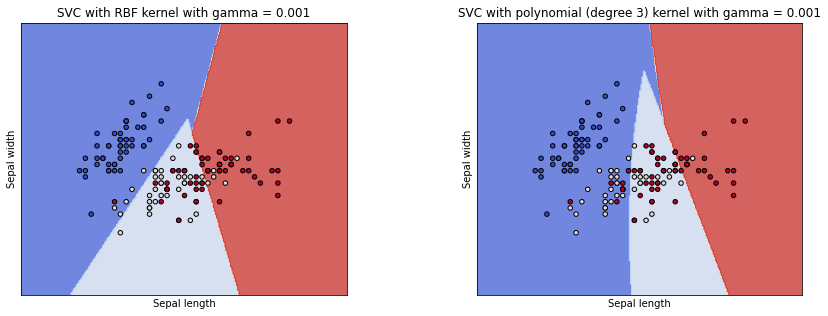

gamma = 0.01


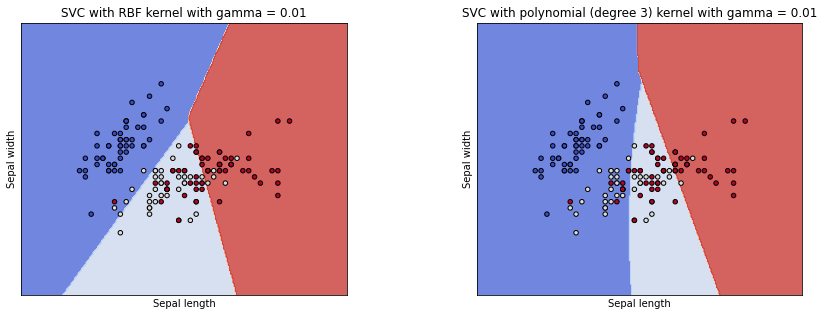

gamma = 0.1


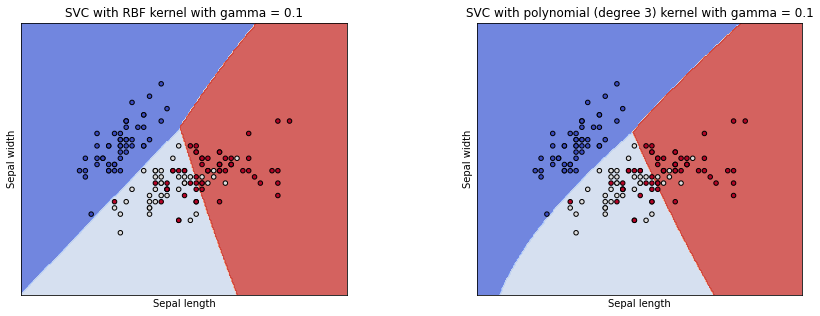

gamma = 1


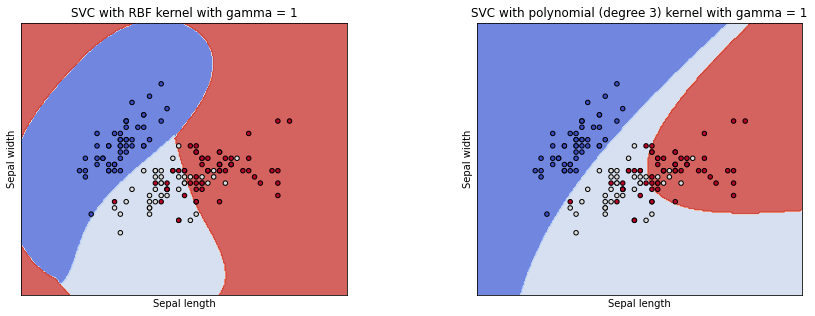

gamma = 10


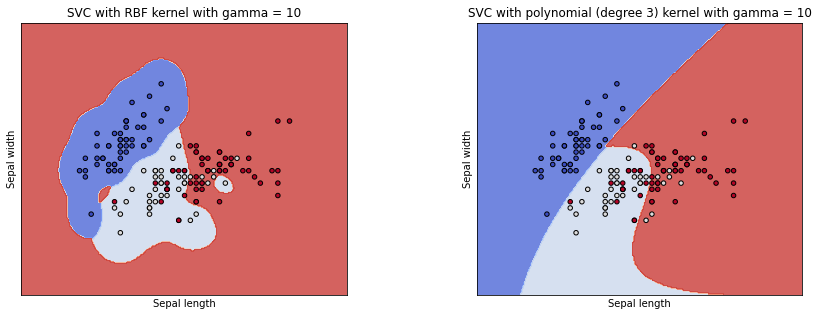

gamma = 100


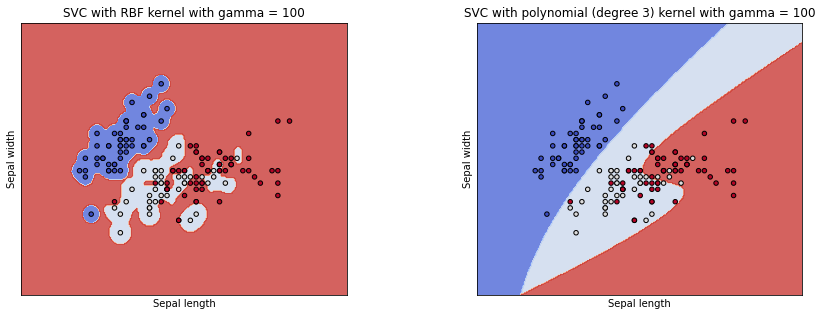

gamma = 1000


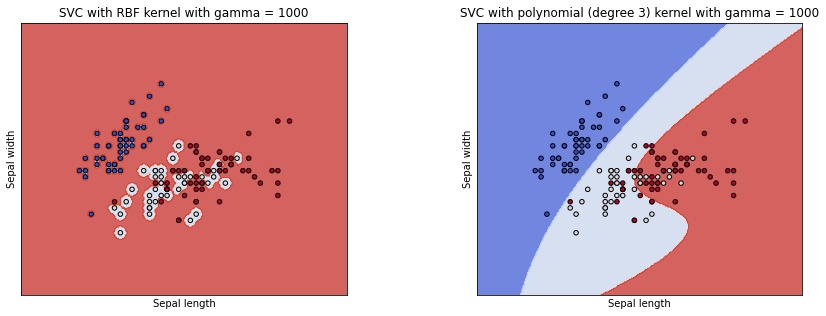

In [7]:
# Visualització de la classificació duta a terme per diversos valors de gamma.

gamma_values = [10**x for x in range(-4,4)]
fig, axes = plt.subplots(10,2,figsize=(10,20))
ax = axes.ravel()
idx=0
for gamma in gamma_values:
    print('gamma = ' + str(gamma))
    ax[idx] = show_gamma_effect(gamma=gamma)
    idx+=1
fig.tight_layout()

degree = 1


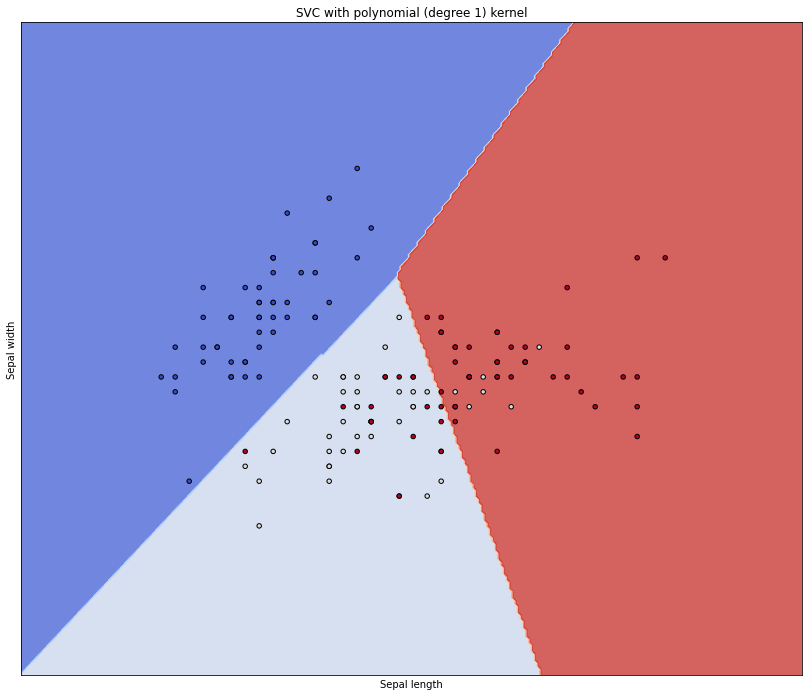

degree = 2


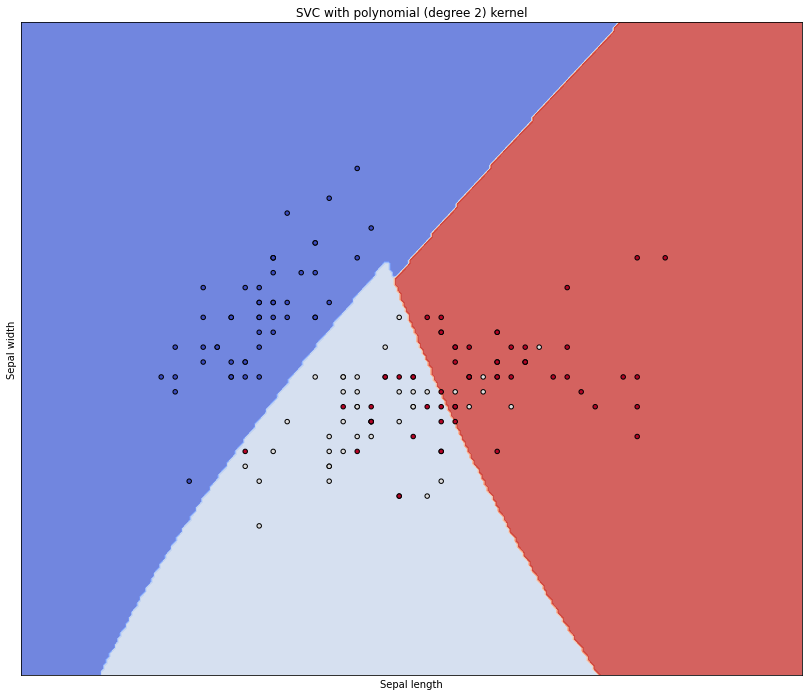

degree = 3


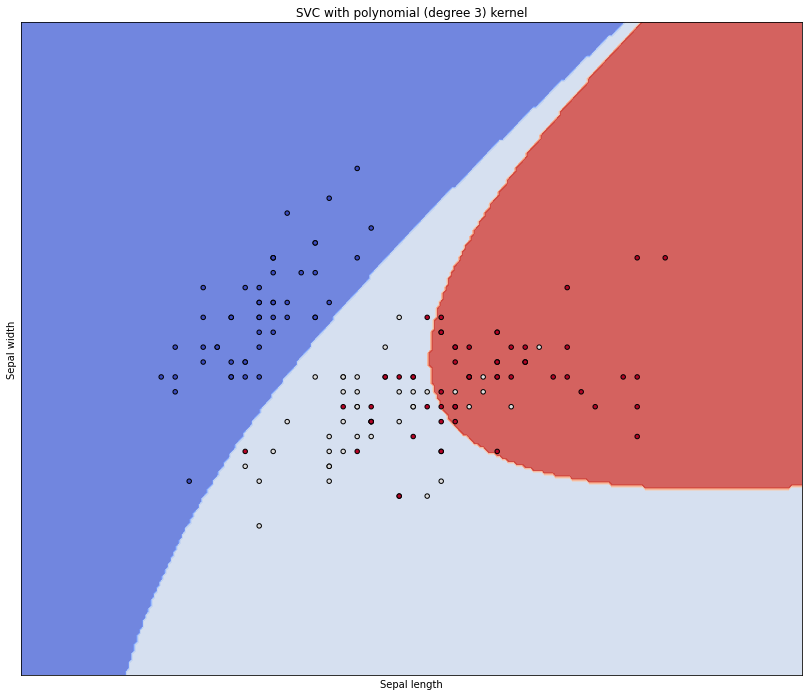

degree = 4


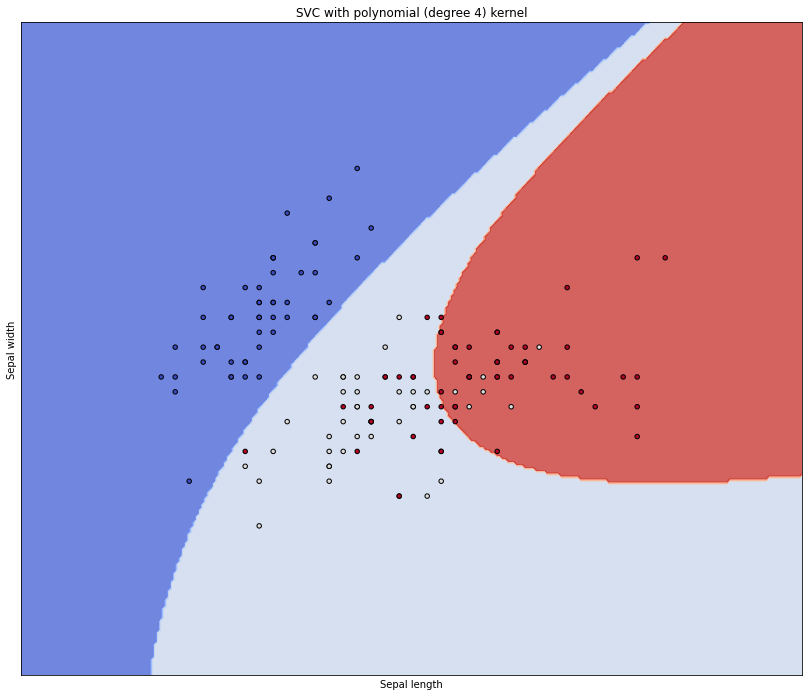

degree = 5


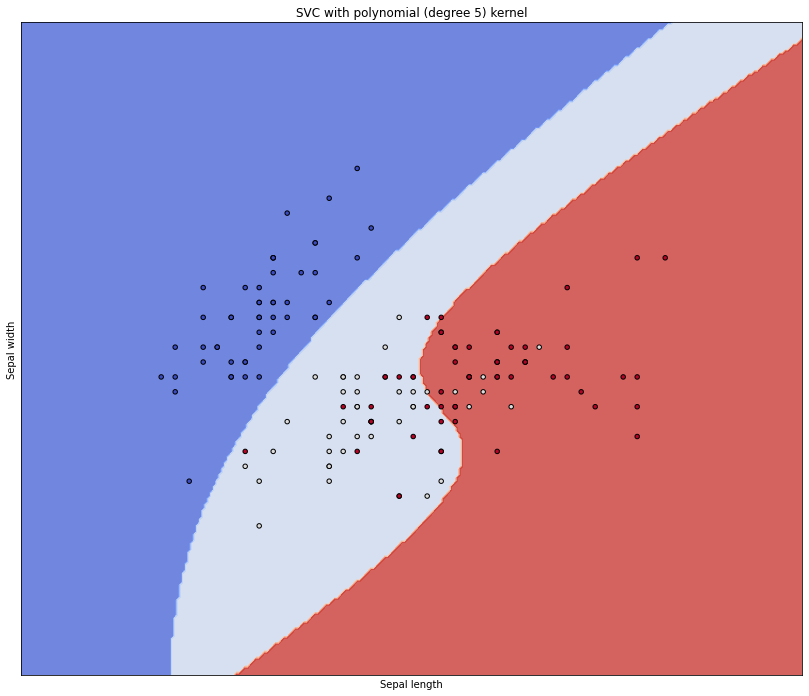

degree = 6


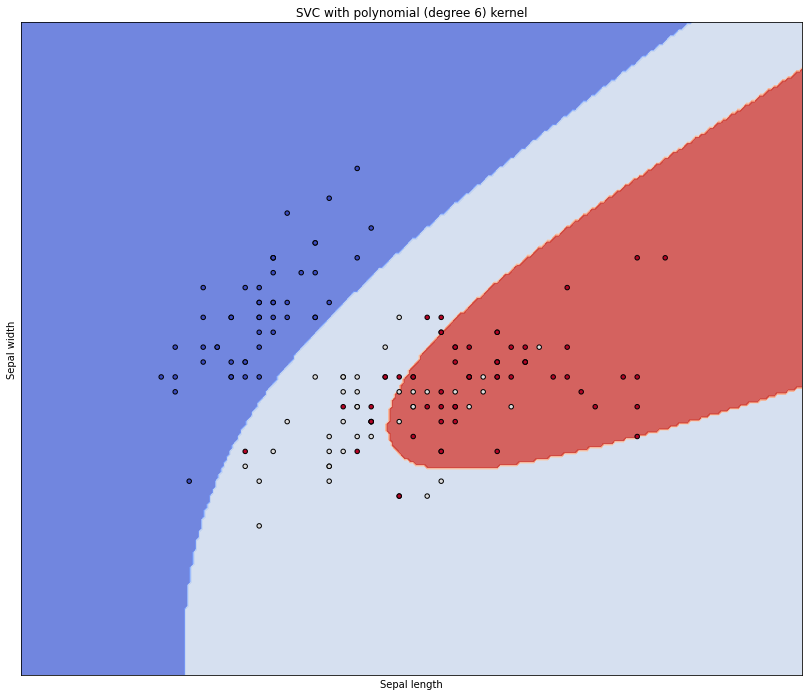

In [8]:
# Visualització de la classificació duta a terme per diversos valors de degree.

degree_values = [x for x in range(1, 7)]
fig, axes = plt.subplots(10,2,figsize=(10,20))
ax = axes.ravel()
idx=0
for degree in degree_values:
    print('degree = ' + str(degree))
    ax[idx] = show_degree_effect(degree=degree)
    idx+=1
fig.tight_layout()


# Apartat A

### 1. Anàlisi exploratori de dades i preprocessament

In [9]:
# Càrrega de llibreries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import pandas as pd
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

In [10]:
# Càrrega de les dades

dataset = load_dataset('train.csv')
data = dataset.values

In [11]:
print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (891, 12)


In [12]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [13]:
x = data[:, :11]
y = data[:, 1]
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de les entrades X (891, 11)
Dimensionalitat de l'atribut Y (891,)


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
# Visualització del nombre de valors no existents per atribut

print(dataset.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [16]:
dataset = dataset.drop(['Name','Ticket','Cabin'],axis=1)
dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
dataset = dataset.dropna()

In [17]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.000,1,0,7.250,S
1,2,1,1,female,38.000,1,0,71.283,C
2,3,1,3,female,26.000,0,0,7.925,S
3,4,1,1,female,35.000,1,0,53.100,S
4,5,0,3,male,35.000,0,0,8.050,S


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB


In [19]:
# Modificacions del dataset.

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
label_encoder_sex = LabelEncoder()
dataset['Embarked'] = label_encoder.fit_transform(dataset['Embarked'])
dataset['Sex'] = label_encoder_sex.fit_transform(dataset['Sex'])
dict(enumerate(label_encoder.classes_)) #S = 2 ; C = 0; Q = 1
dict(enumerate(label_encoder_sex.classes_)) #male = 1 ; female = 0
x = dataset.values[:,dataset.columns != 'Survived']
y = dataset.values[:,1]
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.000,1,0,7.250,2
1,2,1,1,0,38.000,1,0,71.283,0
2,3,1,3,0,26.000,0,0,7.925,2
3,4,1,1,0,35.000,1,0,53.100,2
4,5,0,3,1,35.000,0,0,8.050,2


In [20]:
# Normalització de les dades del dataset.

def normalize_df(df):
    return((df-df.min())/(df.max()-df.min()))

dataset = normalize_df(dataset)

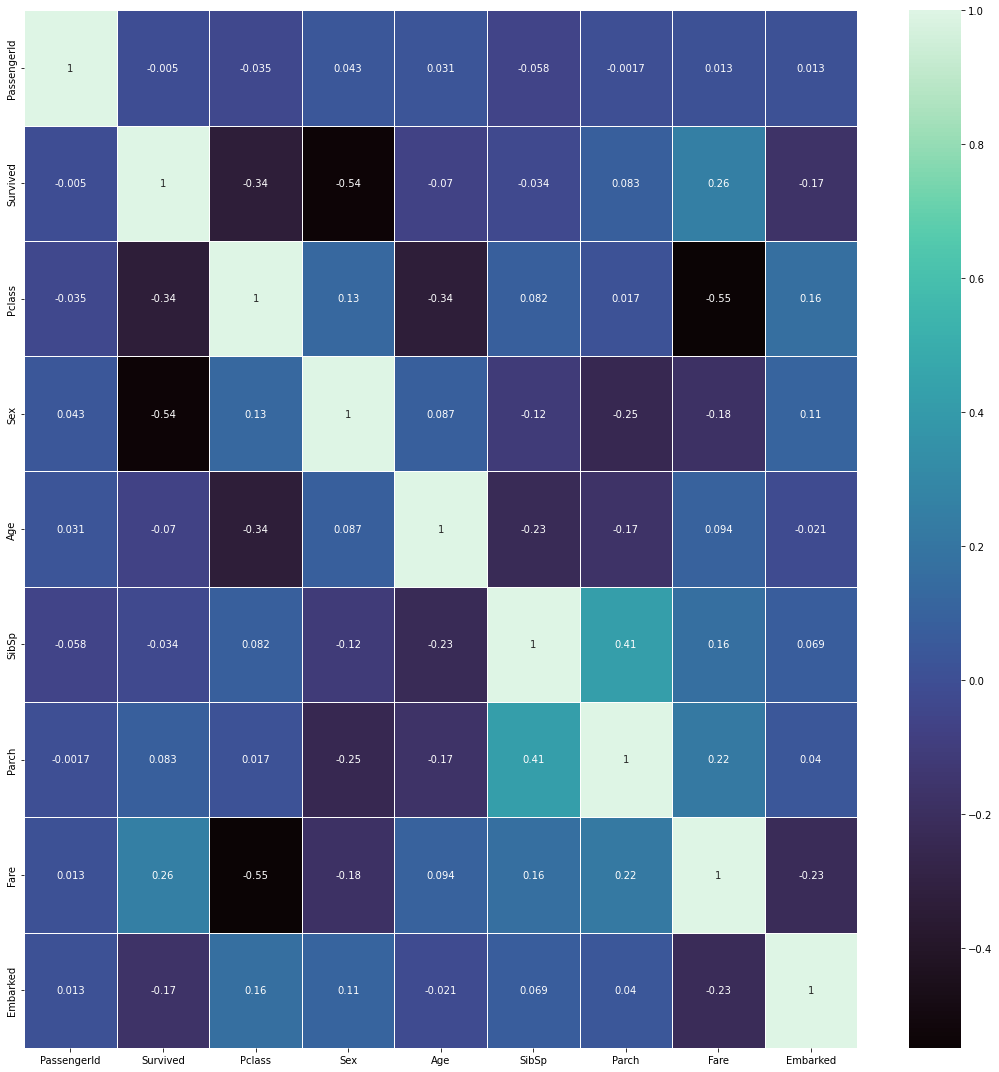

In [21]:
# Visualització de la correlació entre atributs.

import seaborn as sns

correlacio = dataset.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(correlacio, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

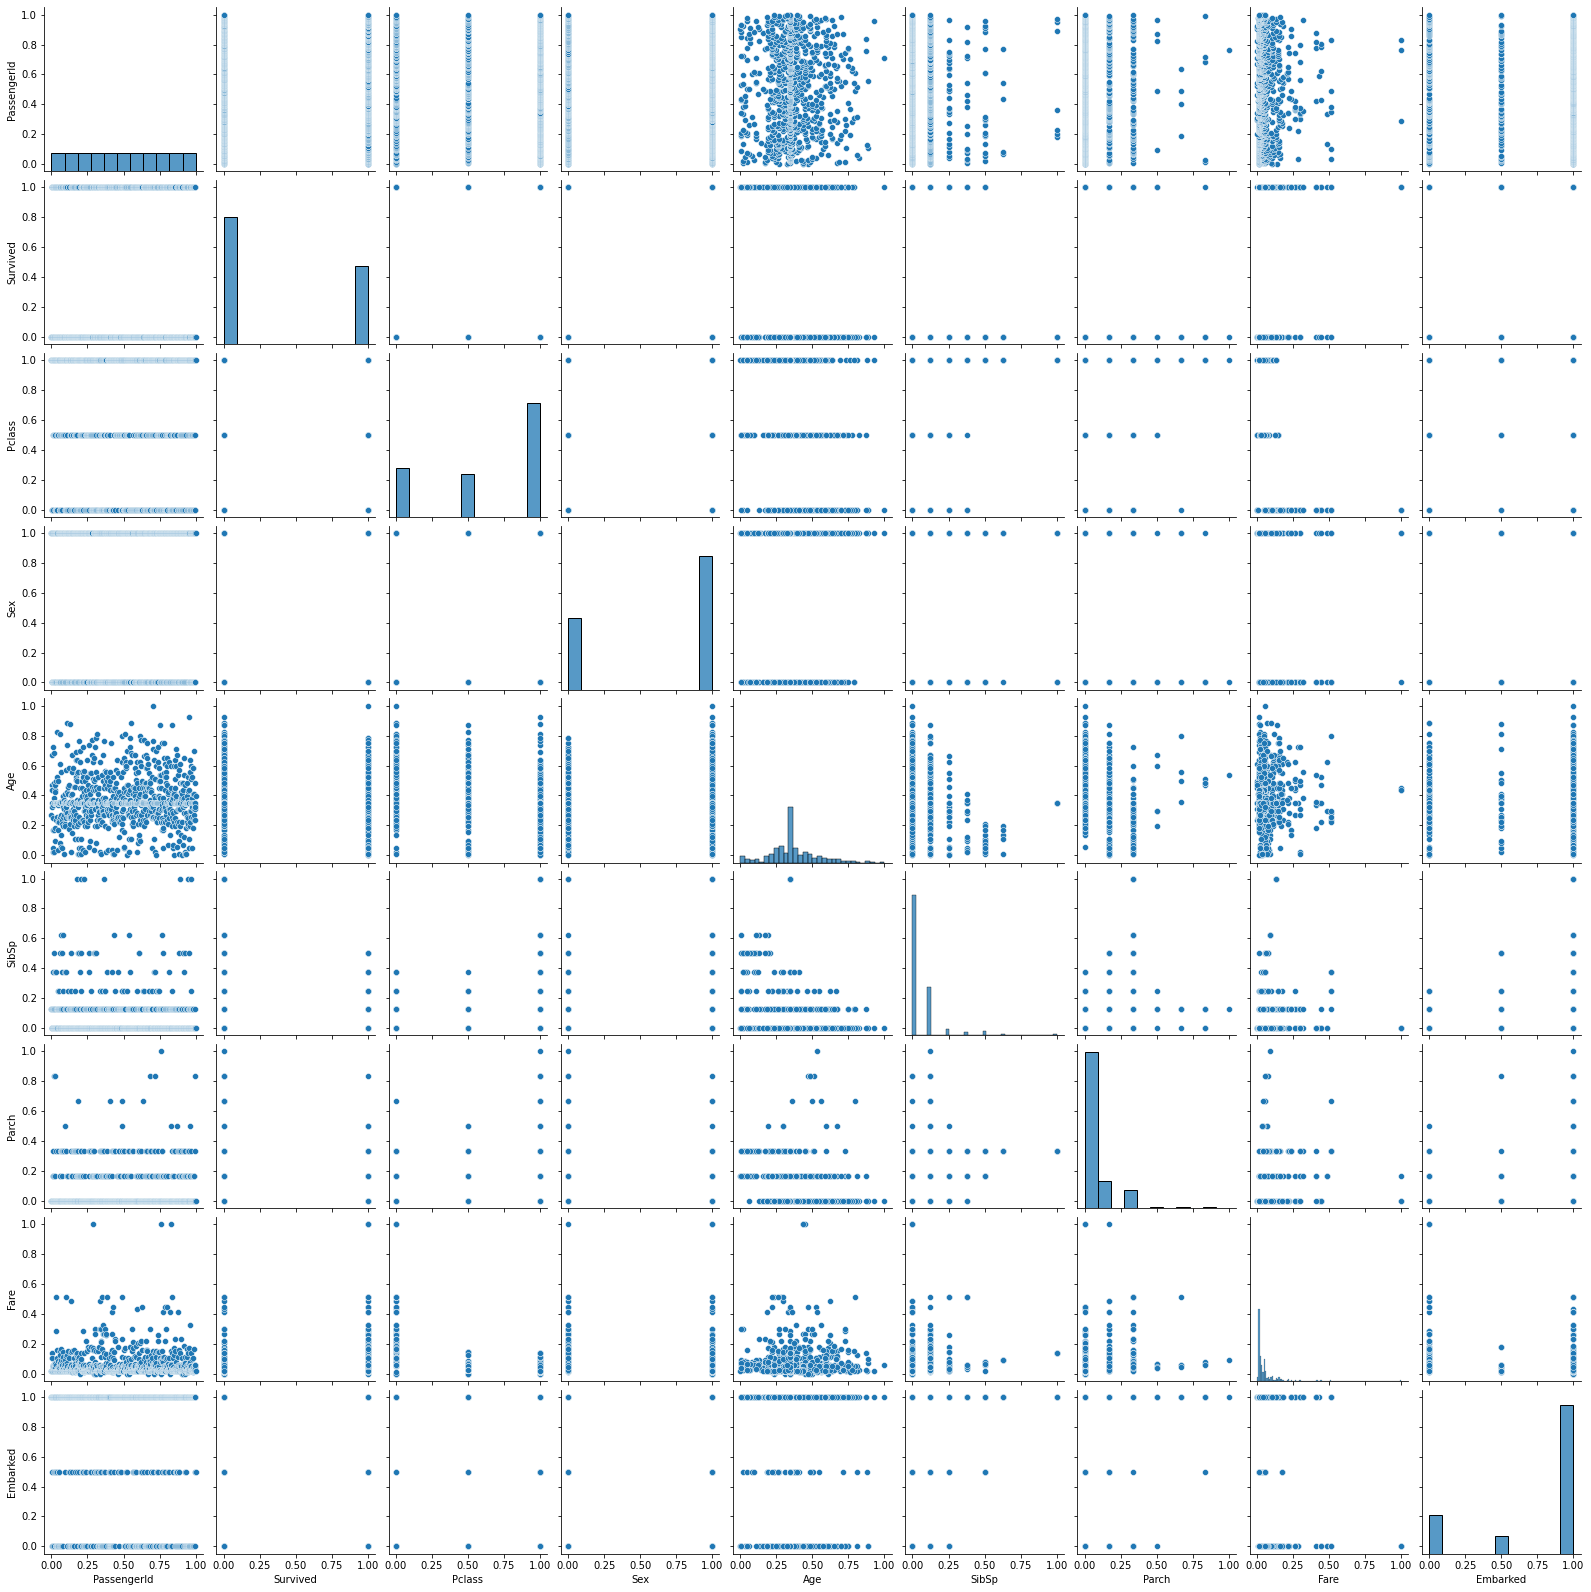

In [22]:
# Pariplots dels atributs

relacio = sns.pairplot(dataset)

In [23]:
# Visualització dels atributs amb major correlació amb "Survived".

correlation_threshold = 0.15
attributes  = list(filter(lambda x: abs(float(dataset.corr()['Survived'].to_frame().T[x])) > correlation_threshold, dataset.columns))
attributes.remove('Survived')
corrTbl = PrettyTable()
corrTbl.field_names = ['Atribut']
for i in range(len(attributes)): 
    corrTbl.add_row([attributes[i]])
print(corrTbl)

+----------+
| Atribut  |
+----------+
|  Pclass  |
|   Sex    |
|   Fare   |
| Embarked |
+----------+


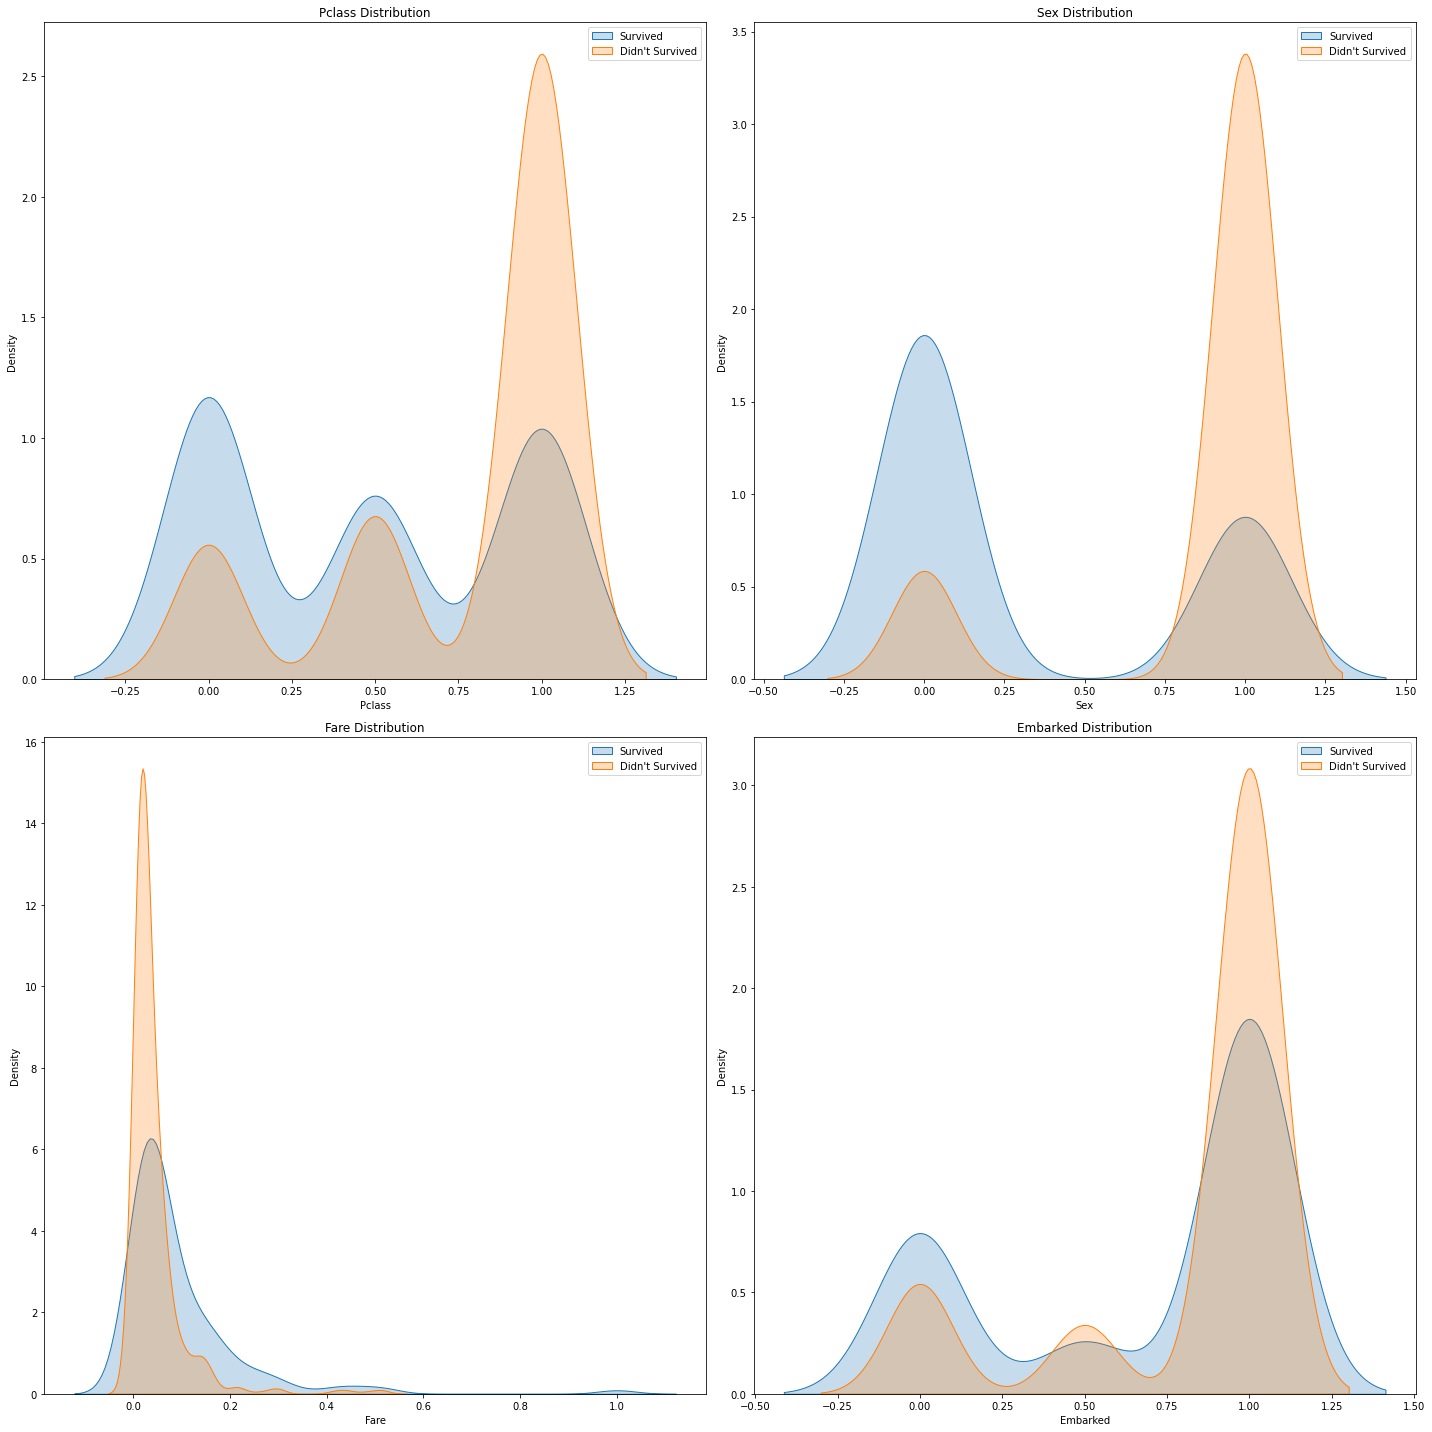

In [24]:
# Distribució dels anteriors quatre atributs segons si "Survived" = 0 o
# "Survived" = 1.

survived = dataset[dataset['Survived']==1]
no_survived = dataset[dataset['Survived']==0]
fig, axes = plt.subplots(2,2, figsize=(20,20))
ax = axes.ravel()

for i in range(len(attributes)): 
    ax[i].set_title(f'{attributes[i]} Distribution')
    if (i==0):
        sns.distplot(survived[attributes[i]], hist=False, kde_kws={'shade':True},label="Survived",ax=axes[0,0])
        sns.distplot(no_survived[attributes[i]], hist=False, kde_kws={'shade': True}, label= "Didn't survived",ax=axes[0,0])
    elif(i==1):
        sns.distplot(survived[attributes[i]], hist=False, kde_kws={'shade':True},label="Survived",ax=axes[0,1])
        sns.distplot(no_survived[attributes[i]], hist=False, kde_kws={'shade': True}, label= "Didn't survived",ax=axes[0,1])
    elif(i==2):
        sns.distplot(survived[attributes[i]], hist=False, kde_kws={'shade':True},label="Survived",ax=axes[1,0])
        sns.distplot(no_survived[attributes[i]], hist=False, kde_kws={'shade': True}, label= "Didn't survived",ax=axes[1,0])
    elif(i==3):
        sns.distplot(survived[attributes[i]], hist=False, kde_kws={'shade':True},label="Survived",ax=axes[1,1])
        sns.distplot(no_survived[attributes[i]], hist=False, kde_kws={'shade': True}, label= "Didn't survived",ax=axes[1,1])
    ax[i].legend(["Survived", "Didn't Survived"], loc="best")
fig.tight_layout()

In [25]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val, indices_train, indices_val

In [26]:
y = dataset['Survived']
X = dataset.drop(['PassengerId', 'Survived'],axis=1)
X_train, y_train, X_test, y_test, indices_train, indices_val = split_data(np.array(X), np.array(y))

### 2. Selecció del model

In [27]:
from sklearn.neural_network import MLPClassifier
#models = [LogisticRegression(), DecisionTreeClassifier(max_depth=7), RandomForestClassifier(n_estimators=1000, max_depth=5), 
#          AdaBoostClassifier(), xgb.XGBClassifier(n_estimators=1000, max_depth=5), MLPClassifier()]
models = [LogisticRegression(random_state=123), DecisionTreeClassifier(random_state=123), RandomForestClassifier(random_state=123), 
          AdaBoostClassifier(random_state=123), xgb.XGBClassifier(random_state=123), MLPClassifier(random_state=123)]
model_names = ["Logistic", "Decision Tree", "Random Forest", "Ada Boost", "XGBoost", "Neural Network"]
idx = 0
tbl = PrettyTable()
tbl.field_names = ['Model', 'Accuracy', 'Temps']
for m in models: 
    start = time.time()
    m.fit(X_train, y_train)
    score = m.score(X_test, y_test)
    end = time.time()
    tbl.add_row([model_names[idx], score, end-start])
    idx+=1

print(tbl)

[00:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+----------------+--------------------+-----------------------+
|     Model      |      Accuracy      |         Temps         |
+----------------+--------------------+-----------------------+
|    Logistic    | 0.8033707865168539 |  0.009005308151245117 |
| Decision Tree  | 0.8146067415730337 | 0.0030117034912109375 |
| Random Forest  | 0.8202247191011236 |  0.21598410606384277  |
|   Ada Boost    | 0.8258426966292135 |  0.10899877548217773  |
|    XGBoost     | 0.8089887640449438 |  0.16699957847595215  |
| Neural Network | 0.8370786516853933 |   0.8680000305175781  |
+----------------+--------------------+-----------------------+


In [28]:
# Proves amb diversos models d'SVM

from sklearn import svm
svm_models= [svm.SVC(kernel='linear', C=10, random_state=123),
              svm.LinearSVC(C=10, max_iter=1000000, random_state=123),
              svm.SVC(kernel='rbf',  C=10, random_state=123),
              svm.SVC(kernel='poly',degree=4, C=10, random_state=123),
              svm.SVC(kernel='sigmoid', C=10, random_state=123)]
svm_kernels = ["Linear","SVC Linear", "RBF", "Polyniomical", "Sigmoid"]
idx= 0
svmtbl = PrettyTable()
svmtbl.field_names = ['Model', 'Accuracy', 'Temps']
for svm in svm_models:
    start =  time.time()
    svm.fit(X_train, y_train)
    score = svm.score(X_test,y_test)
    end = time.time()
    svmtbl.add_row([svm_kernels[idx], score, end-start])
    #print(f"Utilitzant el kernel {svm_kernels[idx]} obtenim una accuracy de: {svm.score(X_train,y_train)}")
    idx+=1

print(svmtbl)

+--------------+--------------------+----------------------+
|    Model     |      Accuracy      |        Temps         |
+--------------+--------------------+----------------------+
|    Linear    | 0.7696629213483146 | 0.029000043869018555 |
|  SVC Linear  | 0.8033707865168539 | 0.061998605728149414 |
|     RBF      | 0.8370786516853933 | 0.04300045967102051  |
| Polyniomical | 0.8258426966292135 | 0.07400012016296387  |
|   Sigmoid    | 0.7640449438202247 | 0.02400064468383789  |
+--------------+--------------------+----------------------+


### 3. Validació encreuada

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
parts = [0.8,0.7,0.6,0.5]
models = [RandomForestClassifier(n_estimators=100), xgb.XGBClassifier()]
model_name = ['Random Forest', 'XGBoost']
cvTbl = PrettyTable()
cvTbl.field_names = ['Model','% of trained data','Accuracy', 'SD']
for part in parts: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   train_size = part,
                                                   test_size=1-part,
                                                   random_state=123)
    idx= 0
    for model in models: 
        scores = cross_val_score(model,X_train,y_train,cv=5)
        #print(scores)
        cvTbl.add_row([model_name[idx],f"{part*100}%", scores.mean(),scores.std()])
        idx+=1

print(cvTbl)

[00:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

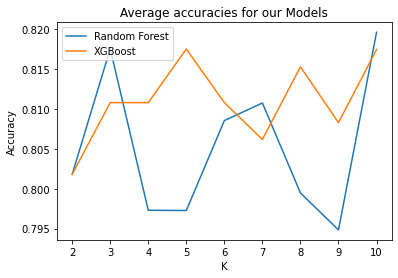

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
models = [RandomForestClassifier(n_estimators=100, random_state=123), xgb.XGBClassifier(random_state=123)]
model_name = ['Random Forest', 'XGBoost']
ascores=[]
axscores=[]

    
    
for k in range(2,11):
    scores = cross_val_score(models[0],X_train,y_train,cv=k)
    ascores.append(scores.mean())
    scores2 = cross_val_score(models[1],X_train,y_train,cv=k)
    axscores.append(scores2.mean())
        #print(scores)
print(type(ascores))
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.set_title("Average accuracies for our Models")
ax.set_xlabel("K")
ax.set_ylabel("Accuracy")

ax.plot([2,3,4,5,6,7,8,9,10], ascores)
ax.plot([2,3,4,5,6,7,8,9,10], axscores)
ax.legend(['Random Forest', 'XGBoost'])

### 4. Anàlisi mètric

In [31]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics
acctbl = PrettyTable()
acctbl.field_names= ["Model", "Accurracy", "Average Precision", "F1Score"]
models = [RandomForestClassifier(n_estimators=100), xgb.XGBClassifier()]
models_name = ['Random Forest','XGBoost']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   train_size = 0.8,
                                                   test_size=0.2,
                                                   random_state=123)
idx=0
for model in models:
    model.fit(X_train, y_train)
    acctbl.add_row([models_name[idx],accuracy_score(y_test,model.predict(X_test)),
          recall_score(y_test, model.predict(X_test)), f1_score(y_test, model.predict(X_test))])
    idx+=1
    
print(acctbl)

[00:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+---------------+--------------------+--------------------+--------------------+
|     Model     |     Accurracy      | Average Precision  |      F1Score       |
+---------------+--------------------+--------------------+--------------------+
| Random Forest | 0.8089887640449438 | 0.7361111111111112 | 0.7571428571428572 |
|    XGBoost    | 0.7921348314606742 | 0.7083333333333334 | 0.7338129496402879 |
+---------------+--------------------+--------------------+--------------------+


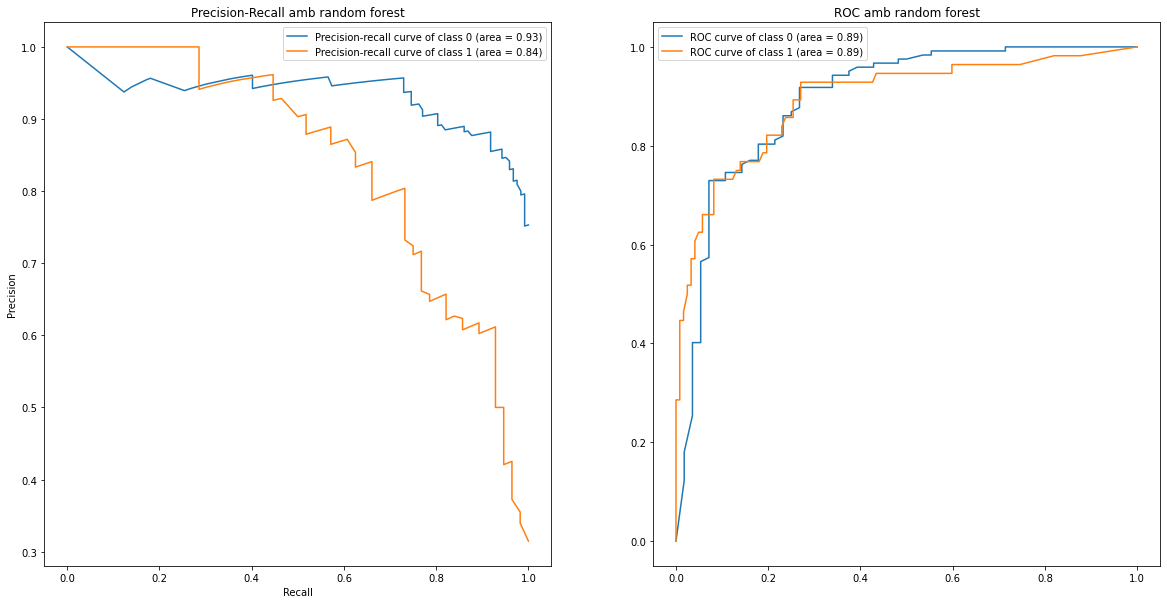

In [116]:
# Càlcul i dibuix de les corbes de precision-recall i ROC pel random forest

n_classes = 2

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
probs = rf.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb random forest', y_v=y_test)
ROC(probs, ax[1], 'ROC amb random forest', y_v=y_test)

[00:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


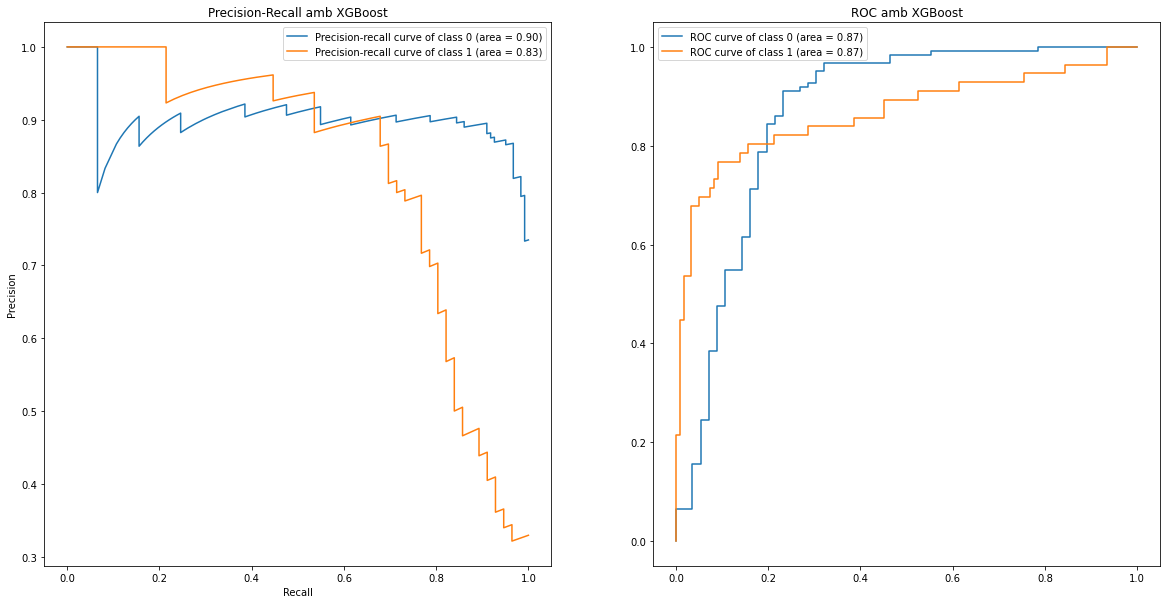

In [117]:
# Càlcul i dibuix de les corbes de precision-recall i ROC per l'XGBoost

n_classes = 2

xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
probs = xg.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb XGBoost', y_v=y_test)
ROC(probs, ax[1], 'ROC amb XGBoost', y_v=y_test)

In [34]:
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)

target_names = ["Didn't Survived","Survived"]
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

Didn't Survived       0.87      0.85      0.86       106
       Survived       0.78      0.81      0.79        72

       accuracy                           0.83       178
      macro avg       0.82      0.83      0.83       178
   weighted avg       0.83      0.83      0.83       178



In [35]:
y_pred = xg.predict(X_test)
target_names = ["Didn't Survived","Survived"]
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

Didn't Survived       0.81      0.85      0.83       106
       Survived       0.76      0.71      0.73        72

       accuracy                           0.79       178
      macro avg       0.79      0.78      0.78       178
   weighted avg       0.79      0.79      0.79       178



Text(32.99999999999999, 0.5, 'True Value')

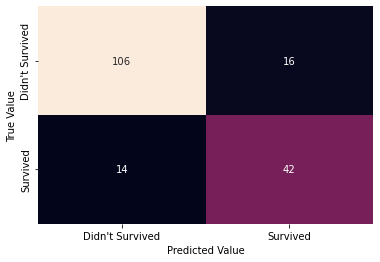

In [118]:
label_aux = plt.subplot()
rf_prediction = rf.predict(X_test)
cm_rf = confusion_matrix(y_test,rf_prediction)
cm_rf_m = pd.DataFrame(cm_rf, index = ["Didn't Survived","Survived"], columns = ["Didn't Survived",'Survived'])
sns.heatmap(cm_rf_m,annot=True,fmt="d", cbar=False)
label_aux.set_xlabel('Predicted Value');label_aux.set_ylabel('True Value')

Text(32.99999999999999, 0.5, 'True Value')

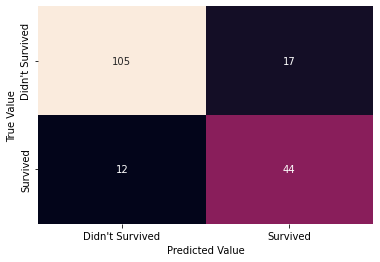

In [119]:
label_aux = plt.subplot()
xb_prediction = xg.predict(X_test)
cm_xb = confusion_matrix(y_test,xb_prediction)
cm_xb_m = pd.DataFrame(cm_xb, index = ["Didn't Survived","Survived"], columns = ["Didn't Survived",'Survived'])
sns.heatmap(cm_xb_m,annot=True,fmt="d", cbar=False)
label_aux.set_xlabel('Predicted Value');label_aux.set_ylabel('True Value')

### 5. Cerca d'hiperparàmetres

In [100]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val, indices_train, indices_val

y = dataset['Survived']
X = dataset.drop(['PassengerId', 'Survived'],axis=1)
X_train, y_train, X_test, y_test, indices_train, indices_val = split_data(np.array(X), np.array(y))

In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 4000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 31,
                                                      32, 32, 33, 34, 35, 36, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 139, 178, 218,
                                                         257, 296, 336, 375,
                                                         415,

In [41]:
rf_random.best_params_

{'n_estimators': 966,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 56,
 'bootstrap': False}

In [110]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.8202247191011236

In [111]:
best_random = rf_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
random_accuracy

0.9438202247191011

In [112]:
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 15.07%.


In [45]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
n_estimators = [int(x) for x in np.linspace(start = 2800, stop = 3200, num = 5)]
param_grid = {
    'bootstrap': [False],
    'max_depth': [42,43,44],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': n_estimators}

In [50]:
rf = RandomForestClassifier(random_state=123)

In [51]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [52]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


{'bootstrap': False,
 'max_depth': 42,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 2800}

In [113]:
best_grid = grid_search.best_estimator_
y = best_grid.predict(X_test)
grid_accuracy = metrics.accuracy_score(y_test, y)
grid_accuracy

0.848314606741573

In [114]:
print('Millora un {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%. amb el randomized'.format( 100 * (grid_accuracy - random_accuracy) / random_accuracy))

Millora un 3.42%.
Millora un -10.12%. amb el randomized


Text(32.99999999999999, 0.5, 'True Value')

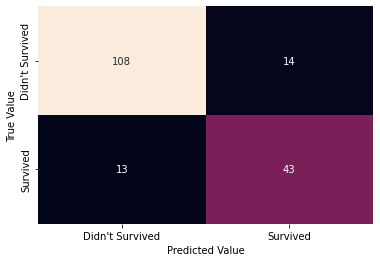

In [120]:
label_aux = plt.subplot()
rf = RandomForestClassifier(n_estimators=2800, bootstrap=False, max_depth=42,max_features='sqrt',min_samples_leaf=4,min_samples_split=8)
rf.fit(X_train,y_train)
rf_prediction = rf.predict(X_test)
cm_rf = confusion_matrix(y_test,rf_prediction)
cm_rf_m = pd.DataFrame(cm_rf, index = ["Didn't Survived","Survived"], columns = ["Didn't Survived",'Survived'])
sns.heatmap(cm_rf_m,annot=True,fmt="d", cbar=False)
label_aux.set_xlabel('Predicted Value');label_aux.set_ylabel('True Value')

In [56]:
random_grid={'max_depth': max_depth,
        'gamma':[i/10.0 for i in range(0,5)],
       'subsample':[i/10.0 for i in range(6,10)],
       'colsample_bytree':[i/10.0 for i in range(6,10)],
    }

In [57]:
xb = xgb.XGBClassifier(random_state=123)
xb_random = RandomizedSearchCV(estimator = xb, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xb_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[00:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [58]:
xb_random.best_params_

{'subsample': 0.9, 'max_depth': 32, 'gamma': 0.4, 'colsample_bytree': 0.8}

In [104]:
base_model = xgb.XGBClassifier(random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

[00:54:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8370786516853933

In [105]:
best_random = xb_random.best_estimator_
y_pred=best_random.predict(X_test)
random_accuracy=best_random.score(X_test,y_test)
random_accuracy

0.9719101123595506

In [106]:
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 16.11%.


In [62]:
random_grid={'max_depth': [i for i in range(70,80,2)],
        'gamma':[0.1,0.2,0.3],
       'subsample':[0.4,0.5,0.6],
       'colsample_bytree':[0.6,0.7,0.8],
    }

In [63]:
xb =  xgb.XGBClassifier(random_state=123)

In [64]:
grid_search = GridSearchCV(estimator = xb, param_grid = random_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [65]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[00:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.8, 'gamma': 0.2, 'max_depth': 70, 'subsample': 0.6}

In [101]:
best_grid = grid_search.best_estimator_
y = best_grid.predict(X_test)
grid_accuracy = metrics.accuracy_score(y_test, y)
grid_accuracy

0.9719101123595506

In [107]:
print('Millora un {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%. amb el randomized'.format( 100 * (grid_accuracy - random_accuracy) / random_accuracy))

Millora un 16.11%.
Millora un 0.00%. amb el randomized


[00:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(32.99999999999999, 0.5, 'True Value')

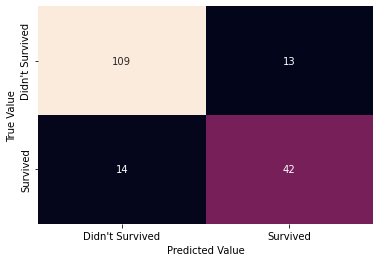

In [103]:
label_aux = plt.subplot()
xb = grid_search.best_estimator_
xb.fit(X_train,y_train)
xb_prediction = xb.predict(X_test)
cm_xb = confusion_matrix(y_test,xb_prediction)
cm_xb_m = pd.DataFrame(cm_xb, index = ["Didn't Survived","Survived"], columns = ["Didn't Survived",'Survived'])
sns.heatmap(cm_xb_m,annot=True,fmt="d", cbar=False)
label_aux.set_xlabel('Predicted Value');label_aux.set_ylabel('True Value')